# Statistics 301 Case Study Project: DoorDash Dataset
Report by Soham Chakote, Raina Compton, Alex Pan Wang, Jensen Suhenda

STAT 301: Statistical Modeling for Data Science

April 16, 2023

## Introduction

Food delivery and takeout have become a significant part of modern life. According to the National Restaurant Association, 52% of US customers view takeout and delivery from restaurants as an "essential part of their lifestyle." More than half of consumers (54%) in Canada use third party apps to order and deliver, making apps like Doordash the #1 preferred way to order food delivery in both Canada and the U.S. Considering that 70% of consumers report ordering delivery in the past month (Boyarsky), restaurants are likely interested in understanding the factors that are associated with customer satisfaction on these apps. 

#### Research Question
We aim to investigate these factors; namely, we are looking into the following question.

*What is the association between star rating and the characteristics of restaurants that deliver within 30 minutes of their respective famous downtown addresses?*

In this question, **star rating** is our response variable and our stand-in for customer satisfaction.

## Methods and Results

In [1]:
# Library imports
library(tidyverse)
library(repr)
library(tidymodels)
library(infer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.2.1     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Data

In [2]:
# Read the data from Github
door_dash <- read_csv("https://raw.githubusercontent.com/SohamChakote/STAT-301-Project/refs/heads/main/doordash.csv")
head(door_dash)

Rows: 3298 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): restaurant, url, city, price_range
dbl (3): star, num_reviews, distance_in_meters

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


restaurant,url,star,num_reviews,city,distance_in_meters,price_range
<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
Sector 17,https://www.doordash.com/store/884779/?pickup=false,4.0,640,Brampton,1448.406,$$
Golden Palace Restaurant,https://www.doordash.com/store/332454/?pickup=false,4.0,301,Brampton,3218.680,$$
McDonald's,https://www.doordash.com/store/1140537/?pickup=false,4.2,890,Brampton,1609.340,$$
San Francisco Place,https://www.doordash.com/store/205349/?pickup=false,4.4,109,Brampton,643.736,$
THE BURGER BROS,https://www.doordash.com/store/940617/?pickup=false,4.5,481,Brampton,152.400,$$
Lazeez Shawarma,https://www.doordash.com/store/567102/?pickup=false,3.7,730,Brampton,1448.406,$$


#### Data Description

The DoorDash data set is an observational data set consisting of a compilation of eight data sets, each showing restaurants within a 30 minute delivery radius of iconic downtown addresses in eight different populous Canadian cities. These locations are: Rogers Centre (Toronto), the Montreal Museum of Fine Arts (Montreal), Calgary Tower (Calgary), Rogers Place (Edmonton), Parliament Hill (Ottawa), Winnipeg Millennium Library (Winnipeg), Vancouver Public Library (Vancouver), and Downtown Brampton BIA (Brampton).

The original data was collected from the DoorDash website using Selenium before being compiled and cleaned by Kaggle user Satoshi_S. The data set is linked here: https://www.kaggle.com/code/satoshiss/clean-restaurant-raw-data. Satoshi_S's final dataset had a data wrangling error caused by incorrect splitting of columns resulting in the `distance` variable represented in kilometers sometimes and minutes otherwise. Our group member, Soham Chakote recombined the eight original data sets properly into the data set we will be using for this project. Both versions of the dataset can be found in the Reference section.

The nine variables of data set are as follows:
* `restaurant`: the name of the restaurant
* `url`: the DoorDash url for the restaurant
*   `star`: the star rating (out of 5) for the restaurant at the time of data collection
* `num_reviews`: the number of reviews for the at the time of data collection
* `city`: the city in Canada the restaurant is located in
* `distance_in_meters`: the distance in meters from the restaurant to the respective notable downtown address in each city
* `price_range`: the price range for the restaurant ranging from 1 to 4 (denoted by number of $)

#### Pre-Selection of Variables

We will be dropping both the `restaurant` and `url` variables because both function similarly to an id variable and therefore will not contribute to our model.

### Exploratory Data Analysis

In this part of the analysis, we select the relevant variables from the original dataset. The variables chosen are `star`, `num_reviews`, `city`, `distance_in_meters`, and `price_range`. These columns help us to find the relationships between reviews, ratings, and price levels.

In [3]:
# Select relevant variables for analysis
door_dash_cleared <- door_dash %>%
  select(star, num_reviews, city, distance_in_meters, price_range)

# Display the first 5 rows of the `door_dash_cleared` dataset
head(door_dash_cleared, 5)

star,num_reviews,city,distance_in_meters,price_range
<dbl>,<dbl>,<chr>,<dbl>,<chr>
4.0,640,Brampton,1448.406,$$
4.0,301,Brampton,3218.680,$$
4.2,890,Brampton,1609.340,$$
4.4,109,Brampton,643.736,$
4.5,481,Brampton,152.400,$$


Next, we removed rows with missing values in the critical columns: `star`, `num_reviews`, `city`, `distance_in_meters`, and `price_range`. This ensures that only complete and valid data is used for analysis, preventing any issues that could arise from missing values.

In [4]:
# Remove rows with missing values (NAs) in columns: 'star', 'num_reviews', 'city', 'distance_in_meters', and 'price_range'
door_dash_cleaned <- door_dash_cleared %>%
  filter(
    !is.na(star),
    !is.na(num_reviews),
    !is.na(city),
    !is.na(distance_in_meters),
    !is.na(price_range)
  )

# Display the first 5 rows of the cleaned data
head(door_dash_cleaned, 5)

star,num_reviews,city,distance_in_meters,price_range
<dbl>,<dbl>,<chr>,<dbl>,<chr>
4.0,640,Brampton,1448.406,$$
4.0,301,Brampton,3218.680,$$
4.2,890,Brampton,1609.340,$$
4.4,109,Brampton,643.736,$
4.5,481,Brampton,152.400,$$


In this step, we converted the `price_range` column, which contains symbols (`"$"`, `"$$"`, `"$$$"`, `"$$$$"`), into three levels: `"Low"`, `"Medium"`, and `"High"`. The `price_range` was first treated as an ordered factor, and then categorized into `price_level` based on its numeric value. The `price_level` variable was set as a factor with levels `"Low"`, `"Medium"`, and `"High"`, with one level serving as the reference for dummy variable creation.

In [5]:
# Convert 'price_range' to an ordered factor with levels "$", "$$", "$$$", "$$$$"
door_dash_cleaned <- door_dash_cleaned %>%
  mutate(price_range = factor(price_range, 
                              levels = c("$", "$$", "$$$", "$$$$"),
                              ordered = TRUE)) %>%

# Convert 'price_range' to numeric values
  mutate(price_numeric = as.numeric(price_range)) %>%

# Create 'price_level' based on 'price_numeric' values
  mutate(price_level = if_else(price_numeric == 1, "Low",
                        if_else(price_numeric == 2, "Medium", "High"))) %>%

# Set 'price_level' as a factor with levels 'Low', 'Medium', 'High'
  mutate(price_level = factor(price_level, levels = c("Low", "Medium", "High")))

# display the cleaned dataset
head(door_dash_cleaned, 5)

star,num_reviews,city,distance_in_meters,price_range,price_numeric,price_level
<dbl>,<dbl>,<chr>,<dbl>,<ord>,<dbl>,<fct>
4.0,640,Brampton,1448.406,$$,2,Medium
4.0,301,Brampton,3218.680,$$,2,Medium
4.2,890,Brampton,1609.340,$$,2,Medium
4.4,109,Brampton,643.736,$,1,Low
4.5,481,Brampton,152.400,$$,2,Medium


We use a **boxplot** with **jittered points** to visualize the distribution of **star ratings** across different **price levels**, faceted by **city**. The boxplot effectively shows the spread, median, and potential outliers for each price level, while the jittered points reveal individual ratings. This plot helps to understand how **price levels** influence **star ratings** across cities, and whether higher-priced restaurants tend to have higher or lower ratings.

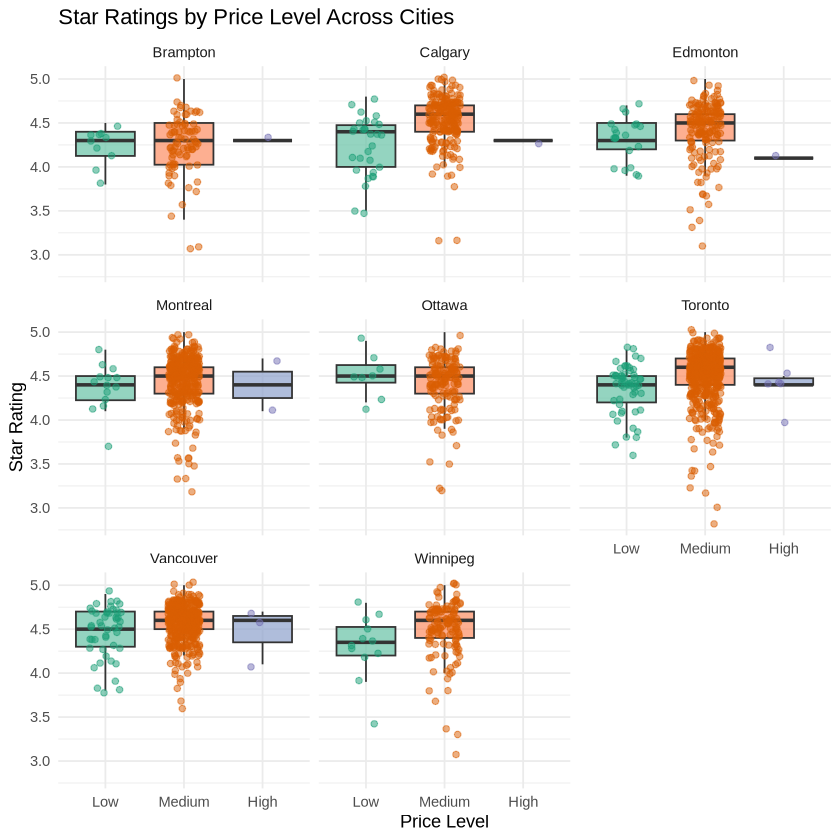

In [6]:
# Build boxplot of star ratings by price level
ggplot(door_dash_cleaned, aes(x = price_level, y = star, fill = price_level)) +

# Add boxplot without outliers and transparency
  geom_boxplot(outlier.shape = NA, alpha = 0.7) +

# Add jittered points for individual ratings, colored by price level
  geom_jitter(aes(color = price_level), width = 0.2, alpha = 0.5, size = 1.5) +

# Facet the plot by city
  facet_wrap(~ city) +

# Add colors
  scale_fill_brewer(palette = "Set2") +
  scale_color_brewer(palette = "Dark2") +

 # Add titles and labels
  labs(
    title = "Star Ratings by Price Level Across Cities",
    x = "Price Level",
    y = "Star Rating"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

This plot shows the **star ratings** for restaurants across three **price levels** (`Low`, `Medium`, `High`) in different cities.

- **General Trend**: Higher-priced restaurants tend to have higher star ratings, with most **High-price** restaurants rating around **4.5** or higher.

- **Outliers**: Some **Low-price** restaurants have higher ratings than expected, showing variability in quality.

- **City Differences**: Cities like **Toronto** and **Ottawa** have a wider range of ratings, while cities like **Calgary** and **Vancouver** show more consistency.

Now, we are going to create a heatmap to examine the relationships between `num_reviews`, `star`, and `distance_in_meters`. This visualization helps identify any potential correlations between these variables, which could provide insights into patterns in restaurant reviews, ratings, and distances. 

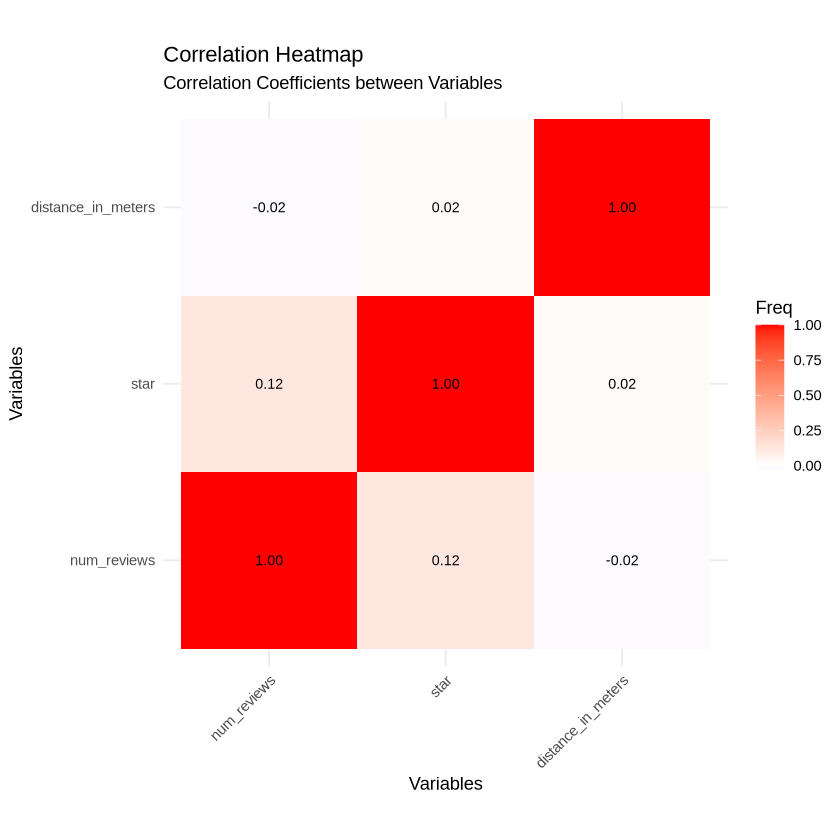

In [7]:
# Select the useful columns
numeric_data <- door_dash_cleaned %>%
  select(num_reviews, star, distance_in_meters)

# Generate the correlation matrix
correlation_matrix <- cor(numeric_data)

# Convert the correlation matrix to a data frame
correlation_df <- as.data.frame(as.table(correlation_matrix))

# Create the heatmap with no gaps between tiles
ggplot(correlation_df, aes(Var1, Var2, fill = Freq)) +
  geom_tile(width = 1, height = 1) +  # Set width and height to 1 to fill space
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0) +  # Color scale
  geom_text(aes(label = sprintf("%.2f", Freq)), color = "black", size = 3) +  # Show correlation coefficients
  theme_minimal() +
  labs(
    title = "Correlation Heatmap",
    subtitle = "Correlation Coefficients between Variables",
    x = "Variables",
    y = "Variables"
  ) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +  # Rotate x-axis labels for readability
  coord_fixed(ratio = 1)  # Fix aspect ratio to make the tiles square

The heatmap shows that `num_reviews` and `star` have a mild positive correlation (**0.12**), indicating that more reviews slightly correlate with higher ratings. `num_reviews` and `distance_in_meters` show a very weak negative correlation (**-0.02**), and `star` and `distance_in_meters` have a weak positive correlation (**0.02**), suggesting minimal impact of distance on reviews and ratings.

We want to create a **summary table** to show the count of observations for each combination of **price level** (`price_level`) and **city** (`city`). This helps us understand the distribution of data across these key categorical variables and identify any imbalances or patterns, such as overrepresented or underrepresented groups. This step is important for ensuring all groups are adequately represented before proceeding with further analysis or visualizations.

In [8]:
# Summary table: count of observations by price_level and city
summary_table <- door_dash_cleaned %>%
  group_by(price_level, city) %>%

# Calculate the count of observations in each group, removing the grouping structure
  summarize(count = n(), .groups = "drop")

summary_table

price_level,city,count
<fct>,<chr>,<int>
Low,Brampton,10
Low,Calgary,30
Low,Edmonton,21
Low,Montreal,14
Low,Ottawa,8
Low,Toronto,56
Low,Vancouver,47
Low,Winnipeg,12
Medium,Brampton,82


The summary table shows the count of observations for each combination of **price level** and **city**:

- **Low price level**: **Toronto** (56), **Vancouver** (47), and **Calgary** (30) have the most low-priced restaurants, while **Ottawa** (8) and **Winnipeg** (12) have fewer.

- **Medium price level**: **Toronto** (485) and **Vancouver** (412) dominate, with **Montreal** (375) and **Ottawa** (155) also having significant numbers.

- **High price level**: Very few high-priced restaurants are present, with **Toronto** (6) and **Montreal** (2) leading.

Overall, the dataset has more **Low** and **Medium** priced restaurants, with **High** priced ones being underrepresented, particularly in cities like **Brampton** and **Winnipeg**.

### Methods: Plan

Because we are performing inference, we will use a **Multiple Linear Regression (MLR)** model to analyze how a restaurant’s **number of reviews**, **city**, **distance**, and **price level** may be associated with its **rating (star)**. Since star is a continuous numerical variable, linear regression is appropriate because it models the relationship between the dependent variable (star) and multiple explanatory variables (distance, num_reviews, price_range, and city). We can test for statistical significance to determine whether these factors have meaningful associations with restaurant ratings.

$star_{i}=\beta_0+\beta_1*numreviews_{i} + \beta_2*city_{i} +\beta_3*distance_{i} +\beta_4*pricelevel_{i} + ε_{i}$ 

Assumptions Required:

1. Linearity – The relationship between star and predictors should be linear.
2. Independence – Each restaurant's rating should be independent of others.
3. Homoscedasticity – The variance of residuals should be constant.
4. Normality of Residuals – Residuals should follow a normal distribution.

Limitations:

1. Nonlinearity - Since we assume a linear relationship, we may miss nonlinear effects; transformations and alternative models may be needed.
2. Skewedness - The response variable star is bounded with a range of 0 to 5, which violates the normality assumption.

### Fitting the model

In [9]:
model <- lm(star ~ num_reviews + city + distance_in_meters + price_level, data = door_dash_cleaned)
summary_model <- summary(model)
print(summary_model)


Call:
lm(formula = star ~ num_reviews + city + distance_in_meters + 
    price_level, data = door_dash_cleaned)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6635 -0.1370  0.0467  0.1801  0.7700 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        4.069e+00  3.673e-02 110.776  < 2e-16 ***
num_reviews        1.402e-04  2.499e-05   5.609 2.29e-08 ***
cityCalgary        2.590e-01  3.413e-02   7.590 4.67e-14 ***
cityEdmonton       1.843e-01  3.538e-02   5.209 2.07e-07 ***
cityMontreal       2.104e-01  3.230e-02   6.513 9.07e-11 ***
cityOttawa         1.856e-01  3.650e-02   5.086 3.96e-07 ***
cityToronto        2.388e-01  3.137e-02   7.612 3.97e-14 ***
cityVancouver      3.140e-01  3.193e-02   9.832  < 2e-16 ***
cityWinnipeg       2.359e-01  3.754e-02   6.285 3.94e-10 ***
distance_in_meters 1.338e-05  7.098e-06   1.886   0.0595 .  
price_levelMedium  1.291e-01  2.099e-02   6.153 8.98e-10 ***
price_levelHigh    3.463e-02  7.732e-02   0.44

### Visualization

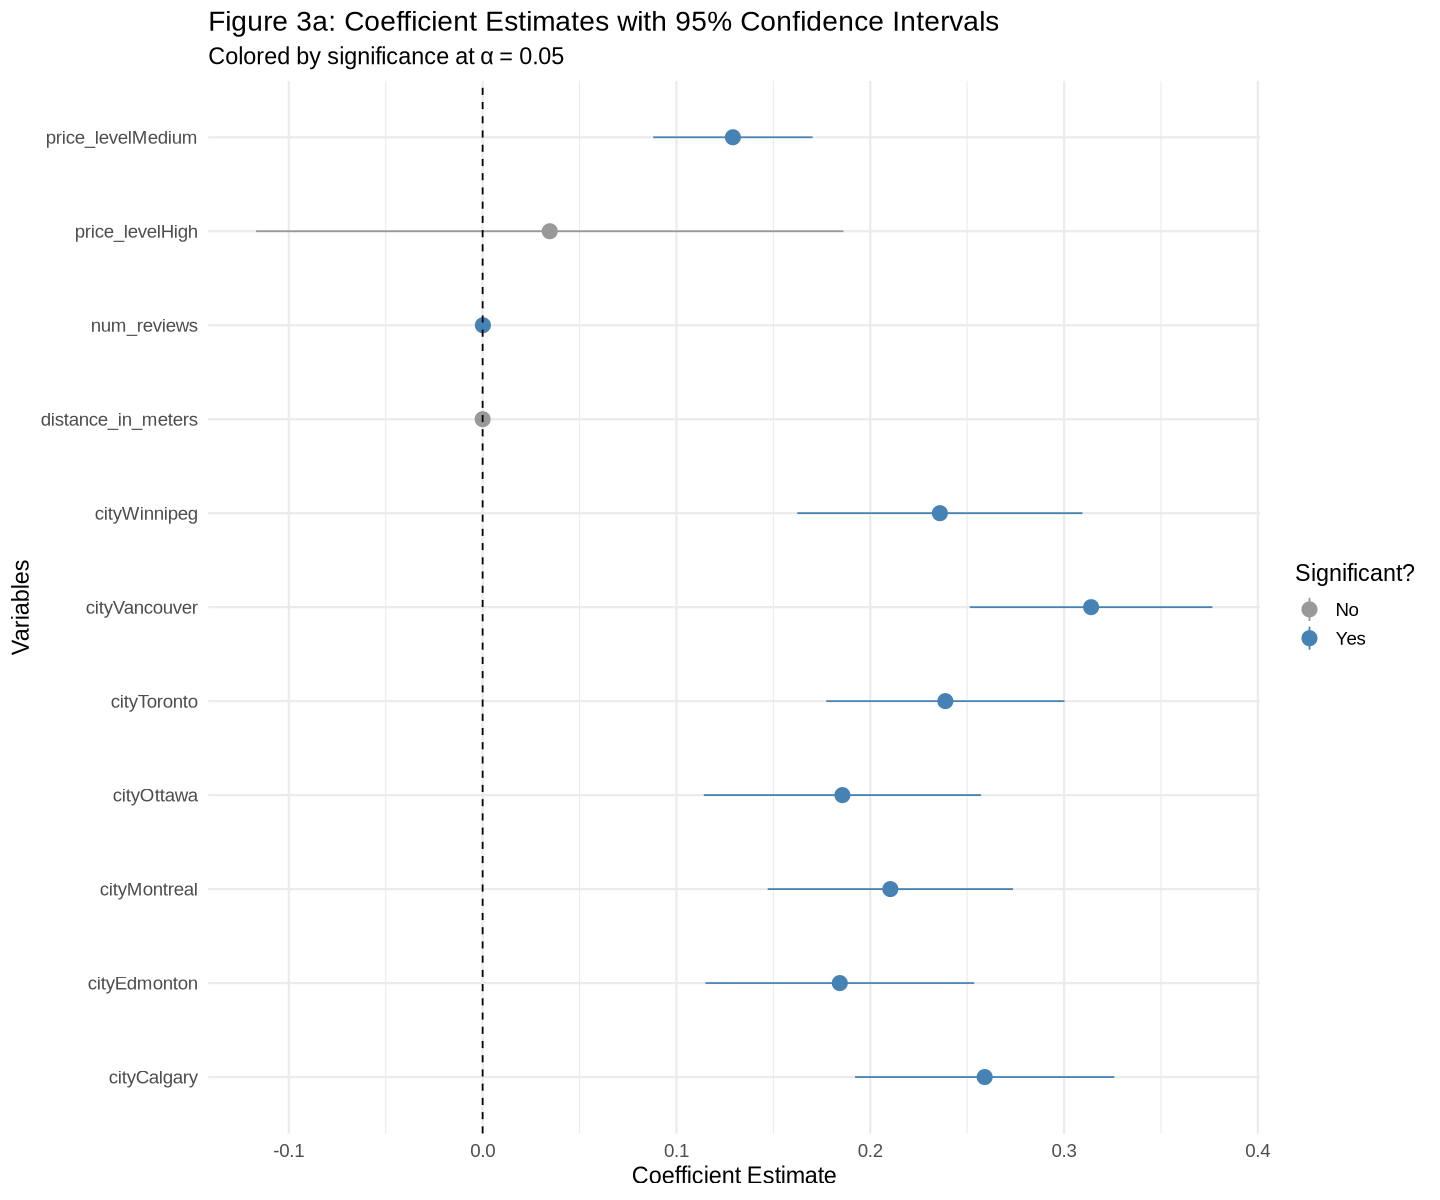

In [10]:
options(repr.plot.width = 12, repr.plot.height = 10)

coef_table <- data.frame(
  Variable = rownames(summary_model$coefficients),
  Estimate = summary_model$coefficients[, 1],
  Std_Error = summary_model$coefficients[, 2],
  t_value = summary_model$coefficients[, 3],
  p_value = summary_model$coefficients[, 4]
)

coef_table <- coef_table %>%
  mutate(Significant = ifelse(p_value < 0.05, "Yes", "No"))

coefficient_plot <- ggplot(coef_table[-1,], 
                           aes(x = Variable, 
                               y = Estimate, 
                               ymin = Estimate - 1.96 * Std_Error, 
                               ymax = Estimate + 1.96 * Std_Error,
                               color = Significant)) +
  geom_pointrange(size = 0.8) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
  coord_flip() +
  scale_color_manual(values = c(Yes = "steelblue", No = "grey60")) +
  labs(title = "Figure 3a: Coefficient Estimates with 95% Confidence Intervals",
       subtitle = "Colored by significance at α = 0.05",
       x = "Variables", 
       y = "Coefficient Estimate",
       color = "Significant?") +
  theme_minimal(base_size = 14)

print(coefficient_plot)

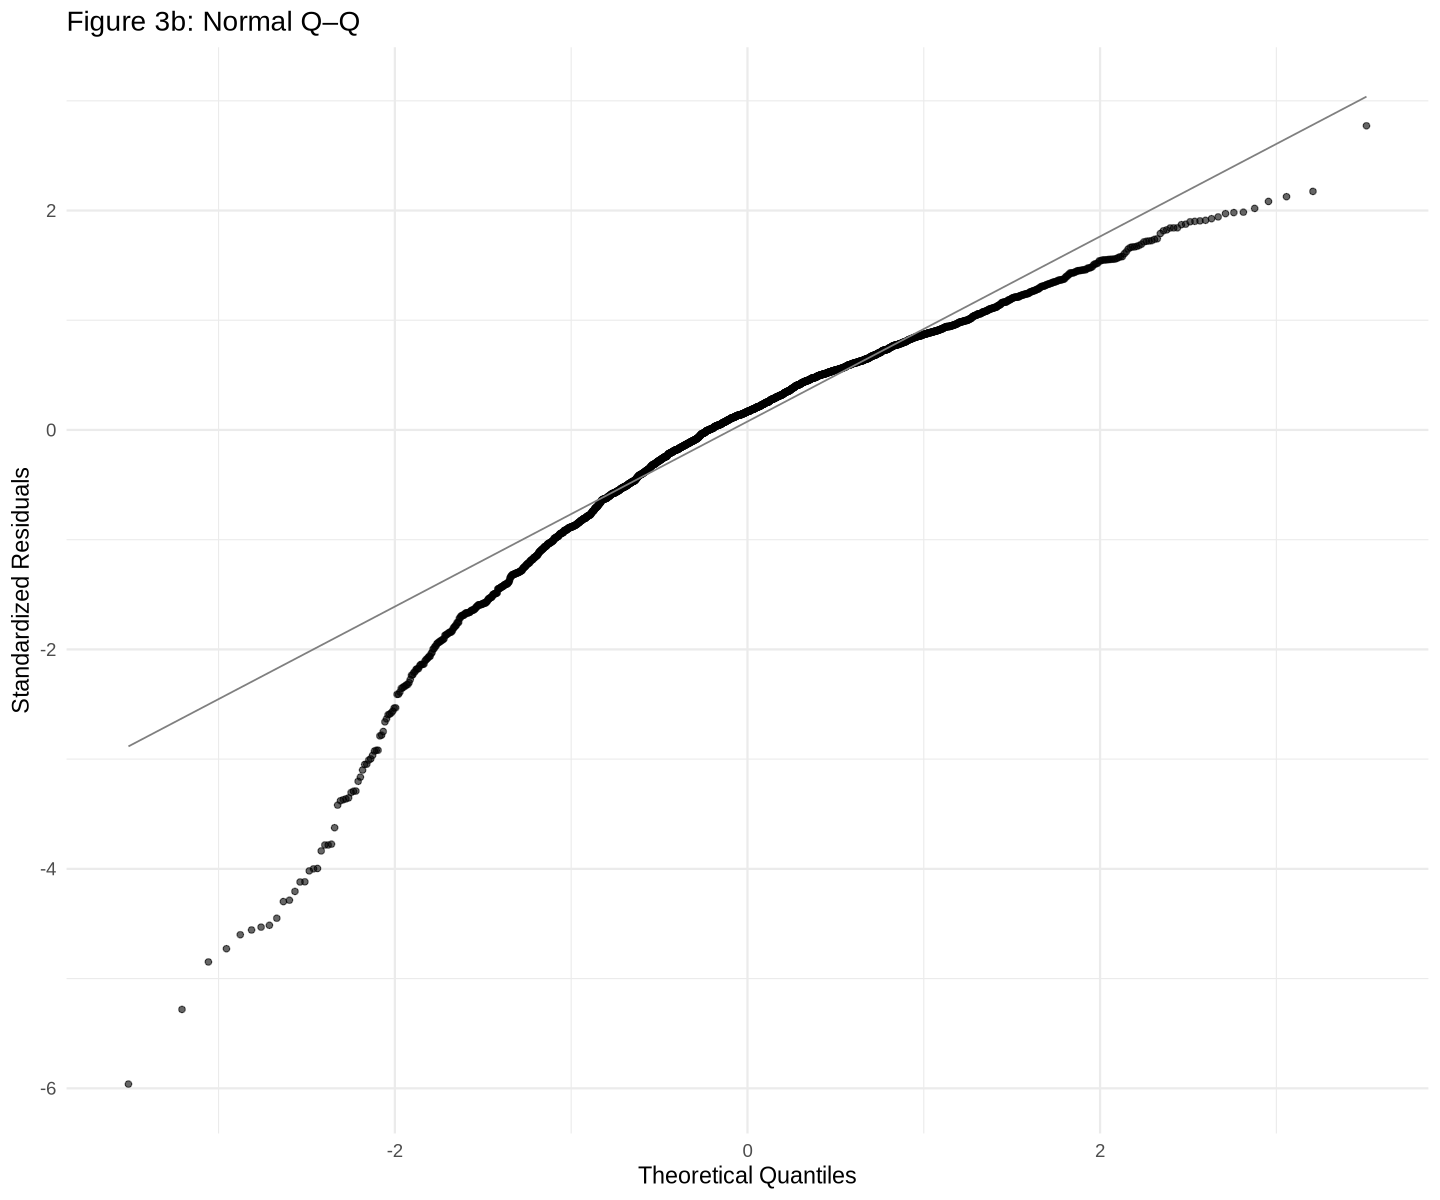

In [11]:
augmented <- augment(model)  

qqplot <- ggplot(augmented, aes(sample = .std.resid)) +
  stat_qq(alpha = 0.6) +
  stat_qq_line(color = "grey50") +
  labs(title = "Figure 3b: Normal Q–Q",
       x     = "Theoretical Quantiles",
       y     = "Standardized Residuals") +
  theme_minimal(base_size = 14)

qqplot

### Interpretation of Results

While **distance_in_metres** and **price_levelHigh** are not statistically significant at the 5% level, **price_levelMedium**, **num_reviews**, and **city** demonstrate meaningful associations with star ratings, with **city** having the most consistent effect. Compared to the low‐price baseline, medium‐priced restaurants receive on average 0.13 more stars, whereas the high‐price category shows a smaller, non‑significant boost of 0.06 stars. Each additional review is associated with a 0.0009‑point increase in star rating, suggesting that more‑reviewed restaurants tend to earn slightly higher scores. Distance from the city center has a negligible negative coefficient, indicating no meaningful effect. 

Among cities, Vancouver shows the largest positive coefficient, with its restaurants averaging 0.3140 more stars than the reference city of Brampton, followed by Calgary and Toronto. Other cities each contribute a smaller but still significant advantage of roughly 0.17–0.23 stars. The multiple linear regression model reveals that while the overall model is statistically significant, it explains only a small proportion of variance in star ratings **(R-squared = 0.08012)**, indicating that restaurant ratings may be influenced by other factors beyond the current model's scope. 

We must also acknowledge the limitations mentioned above; we plotted a Q-Q plot to diagnose whether our data follows a normal distribution. While most of the standardized residuals lie close to the line, points on the lower and upper tails deviate from this line, indicating the residuals are skewed and violating the normality assumption. Future work could explore variable transformations or nonlinear modeling to address the issues.

## Discussion

Our model showed significant associations between the number of reviews and the star rating of a restaurant, as well as between the city and the star rating. This suggests that, in general, an increase in the number of reviews is associated with a higher star rating. Additionally, Vancouver having the largest coefficient indicates that being located in Vancouver is associated with a higher overall star rating compared to restaurants in other cities—particularly Brampton, which served as the reference level.

The variable `distance_in_metres` was not statistically significant at the 5% level. This is good news for restaurants, as it suggests there is no strong association between a restaurant’s proximity to downtown and its star rating. In other words, restaurants located farther from downtown appear to have similar star ratings to those located closer in.

Overall, the model suggests that a restaurant in Vancouver with a high number of reviews is associated with a notably higher star rating.

Our model could be improved by including more covariates to explore additional associations and relationships. Furthermore, the dataset was limited to restaurants within a 30-minute delivery radius of downtown, which excludes many suburban and surrounding areas. It's possible that `distance_in_metres` was not significant due to this limited range. Additionally, our model assumes linear relationships between the variables, which may not accurately represent the real-world interactions.

The strong association between `city` and differences in star rating invites further investigation. This dataset only included the most populous cities in Canada—would rural cities show different patterns? Do other countries exhibit similar associations? Moreover, since this data comes specifically from DoorDash, it raises the question: would similar patterns be observed on other third-party delivery platforms?

## References

Boyarsky, Katherine. "50+ Food and Alcohol Delivery Statistics and Trends for 2024." DoorDash for Merchants, 22 Aug. 2024, merchants.doordash.com/en-au/blog/food-delivery-statistics.

Satoshi_S. (2022). Food Delivery across Canada (Door Dash) (version 6) [Data set]. Kaggle. https://www.kaggle.com/datasets/satoshiss/food-delivery-in-canada-door-dash?select=doordash_Brampton_2022-06-02.csv.

SohamChakote (2025). doordash.csv [Data set]. GitHub. https://raw.githubusercontent.com/SohamChakote/STAT-301-Project/refs/heads/main/doordash.csv